Akbar
Submission 2

In [1]:
# Menginstal package kaggle
!pip install -q kaggle

In [2]:
from google.colab import files

# Mengupload file json dari profile kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akbartolandy","key":"52c6001a3de19543a368743e284fa79b"}'}

In [3]:
# Membuat direktory dan mengubah izin file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
# Mendownload dataset
!kaggle datasets download -d cornflake15/denpasarbalihistoricalweatherdata

 68% 5.00M/7.32M [00:01<00:00, 3.85MB/s]
100% 7.32M/7.32M [00:01<00:00, 5.56MB/s]


In [5]:
# Ekstrak file zip dan melihat isi dataset
!mkdir denpasarbalihistoricalweatherdata
!unzip denpasarbalihistoricalweatherdata.zip -d denpasarbalihistoricalweatherdata
!ls denpasarbalihistoricalweatherdata

Archive:  denpasarbalihistoricalweatherdata.zip
  inflating: denpasarbalihistoricalweatherdata/openweatherdata-denpasar-1990-2020.csv  
  inflating: denpasarbalihistoricalweatherdata/openweatherdata-denpasar-1990-2020v0.1.csv  
openweatherdata-denpasar-1990-2020.csv
openweatherdata-denpasar-1990-2020v0.1.csv


In [6]:
import numpy as np
import pandas as pd

# Mengubah dataset menjadi dataframe
df = pd.read_csv('denpasarbalihistoricalweatherdata/openweatherdata-denpasar-1990-2020v0.1.csv')

In [7]:
df.head()

,dt_iso,timezone,city_name,lat,lon,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,rain_6h,rain_12h,rain_24h,rain_today,snow_1h,snow_3h,snow_6h,snow_12h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1/1/1990 0:00,28800,Denpasar,-8.652497,115.219117,25.82,25.82,25.82,1010.0,86,1.36,225,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98,500,Rain,light rain,10d
1,1/1/1990 1:00,28800,Denpasar,-8.652497,115.219117,26.20,26.20,26.20,1011.0,84,2.09,247,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91,500,Rain,light rain,10d
2,1/1/1990 2:00,28800,Denpasar,-8.652497,115.219117,26.45,26.45,26.45,1011.0,84,2.44,262,0.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94,500,Rain,light rain,10d
3,1/1/1990 3:00,28800,Denpasar,-8.652497,115.219117,26.80,26.80,26.80,1011.0,82,2.29,271,0.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94,500,Rain,light rain,10d
4,1/1/1990 4:00,28800,Denpasar,-8.652497,115.219117,27.04,27.04,27.04,1010.0,82,1.71,274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76,803,Clouds,broken clouds,04d


In [8]:
# Melihat isi total dari data
df.shape

(264924, 29)

In [9]:
# Mengecek nilai null
df.isnull().sum()

dt_iso                      0
timezone                    0
city_name                   0
lat                         0
lon                         0
temp                        0
temp_min                    0
temp_max                    0
pressure                    0
humidity                    0
wind_speed                  0
wind_deg                    0
rain_1h                248638
rain_3h                248768
rain_6h                228826
rain_12h               264912
rain_24h               258107
rain_today             264924
snow_1h                264924
snow_3h                264924
snow_6h                264924
snow_12h               264924
snow_24h               264924
snow_today             264924
clouds_all                  0
weather_id                  0
weather_main                0
weather_description         0
weather_icon                0
dtype: int64

In [10]:
# Memilih kolom yang akan digunakan
df = df.iloc[200000:264924][['dt_iso', 'temp']]

In [11]:

# Konversi dt_iso ke Datetime Format
df['dt_iso'] = pd.to_datetime(df['dt_iso'])

# Mengubah nama kolom dt_iso
df.rename(columns={'dt_iso':'date'}, inplace=True)
df.head()

,date,temp
200000,2012-09-02 00:00:00,24.70
200001,2012-09-02 01:00:00,25.28
200002,2012-09-02 02:00:00,27.08
200003,2012-09-02 03:00:00,27.07
200004,2012-09-02 04:00:00,27.70


In [12]:
df.isnull().sum()

date    0
temp    0
dtype: int64

In [13]:
new_df = df[['date', 'temp']].copy()
new_df.set_index('date', inplace= True)

#resampling data menjadi mean tiap tanggal
new_df = new_df.resample('D').mean()
new_df.head()

,temp
date,
2012-09-02,25.619167
2012-09-03,26.237917
2012-09-04,26.379167
2012-09-05,26.411250
2012-09-06,25.909167


In [14]:
df.isnull().sum()

date    0
temp    0
dtype: int64

Text(0.5, 1.0, 'Temperature average')

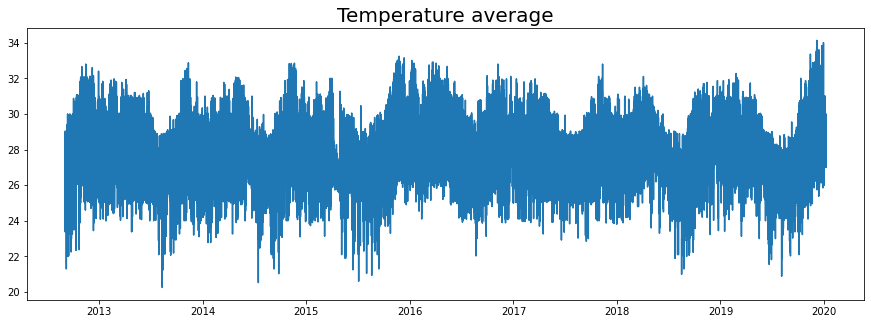

In [15]:
import matplotlib.pyplot as plt

dates = df['date'].values
temp = df['temp'].values

# Membuat plot data
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average', fontsize=20)

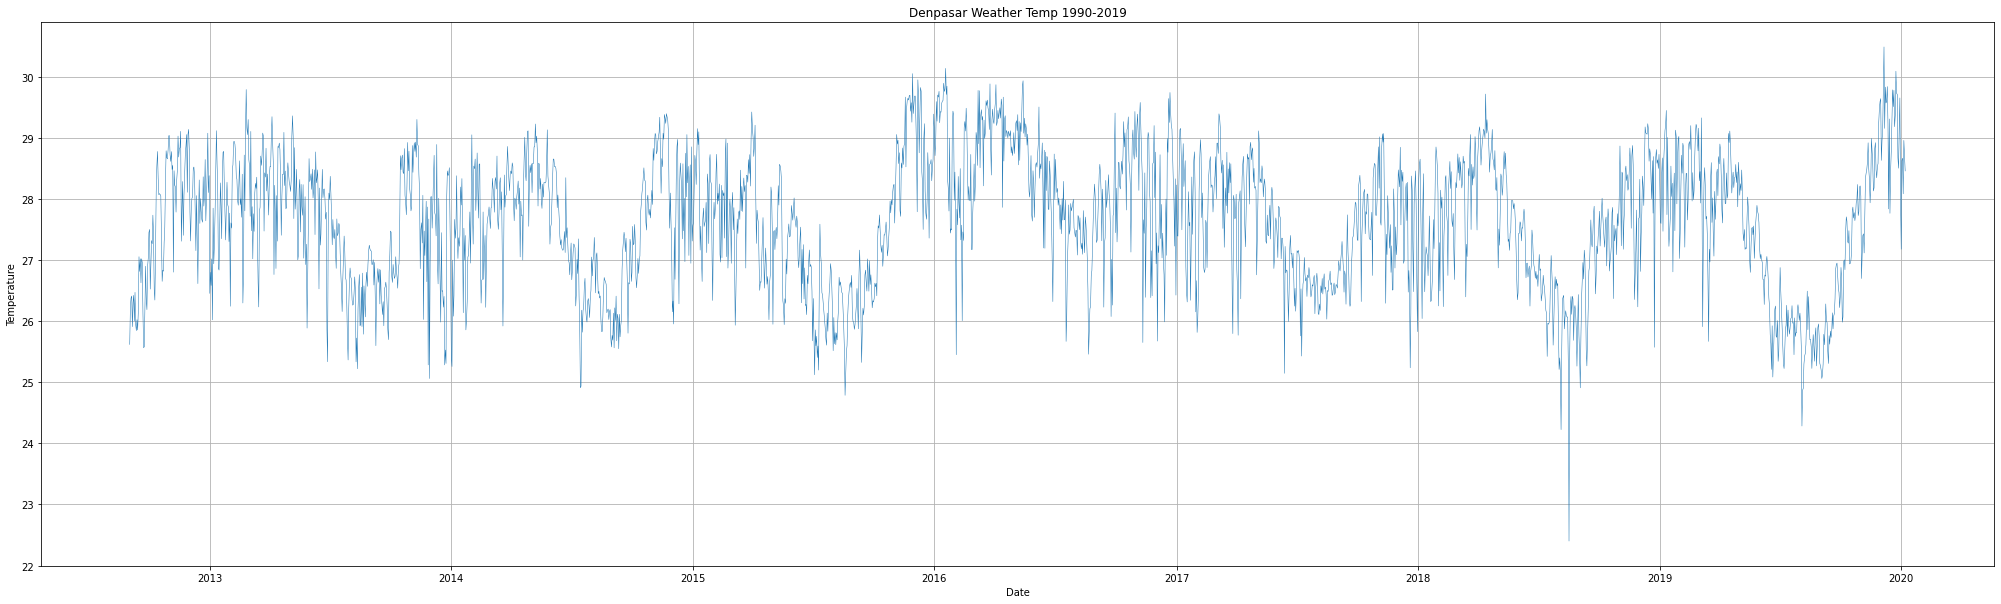

In [16]:
plt.figure(figsize=(35, 10))
plt.plot(new_df, linewidth=.5)
plt.grid()
plt.title('Denpasar Weather Temp 2013-2019')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

In [17]:
from sklearn.model_selection import train_test_split

# Membagi dataset menjadi train dan test
X_train, X_test, Y_train, Y_test = train_test_split(temp, dates, test_size=0.2, shuffle=False)

print(len(X_train), len(X_test))

51939 12985


In [18]:
# merubah data menjadi format yang dapat diterima oleh model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [19]:
import tensorflow as tf
from keras.layers import Dense, LSTM

train_set = windowed_dataset(X_train, window_size=32, batch_size=64, shuffle_buffer=1000)
val_set = windowed_dataset(X_test, window_size=32, batch_size=64, shuffle_buffer=1000)

model = tf.keras.models.Sequential([                               
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [20]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

In [21]:
min_mae = (new_df['temp'].max() - new_df['temp'].min()) * 0.1
print(min_mae)

0.808625


In [22]:
# Membuat custom callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < min_mae):
      print('\nMAE has reach < 10% from total data!')
      self.model.stop_training = True

cust_callbacks = myCallback()

In [23]:
from keras.callbacks import ReduceLROnPlateau

hist = model.fit(train_set, validation_data=val_set, 
                 epochs=100, callbacks=[cust_callbacks, ReduceLROnPlateau()])

Epoch 1/100
812/812 [==============================] - 48s 53ms/step - loss: 11.7413 - mae: 12.2018 - val_loss: 1.1205 - val_mae: 1.5481
Epoch 2/100
812/812 [==============================] - 41s 50ms/step - loss: 0.9192 - mae: 1.3436 - val_loss: 1.0580 - val_mae: 1.4884
Epoch 3/100
812/812 [==============================] - 41s 50ms/step - loss: 0.8788 - mae: 1.3018 - val_loss: 1.0172 - val_mae: 1.4428
Epoch 4/100
812/812 [==============================] - 41s 50ms/step - loss: 0.8059 - mae: 1.2234 - val_loss: 0.8607 - val_mae: 1.2784
Epoch 5/100
812/812 [==============================] - 41s 50ms/step - loss: 0.6775 - mae: 1.0834 - val_loss: 0.7026 - val_mae: 1.0972
Epoch 6/100
812/812 [==============================] - 41s 50ms/step - loss: 0.4978 - mae: 0.8800 - val_loss: 0.5280 - val_mae: 0.9357
Epoch 7/100
812/812 [==============================] - 41s 50ms/step - loss: 0.2998 - mae: 0.6333 - val_loss: 0.2853 - val_mae: 0.6221

MAE has reach < 10% from total data!


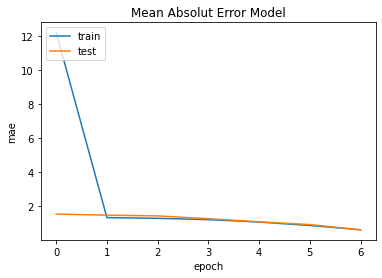

In [24]:
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('Mean Absolut Error Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

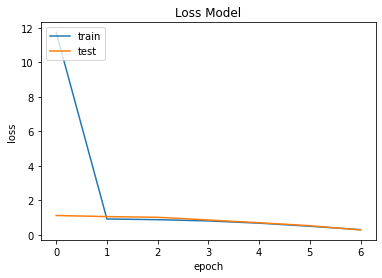

In [25]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()